In [4]:
from pathlib import Path
DATA_DOWNLOAD_DIR = Path.home()

In [5]:
import glob
import os
import pandas as pd
from emg2pose.data import Emg2PoseSessionData
import numpy as np
from scipy import stats
from scipy.signal import find_peaks
import pickle
import matplotlib.pyplot as plt
stages = sorted(glob.glob(os.path.join(DATA_DOWNLOAD_DIR, "emg2pose_dataset_mini/*.hdf5")))

stage = stages[15]
data = Emg2PoseSessionData(hdf5_path=stage)


metadata_df = pd.read_csv(DATA_DOWNLOAD_DIR / "emg2pose_dataset_mini/metadata.csv")
metadata_df.head(5)

,session,user,stage,start,end,side,filename,moving_hand,held_out_user,held_out_stage,split,generalization
0,2022-04-07-1649318400-8125c-cv-emg-pose-train@2,29ddab35d7,ThumbsUpDownThumbRotationsCWCCWP,1.649400e+09,1.649400e+09,left,2022-04-07-1649318400-8125c-cv-emg-pose-train@...,both,True,False,val,user
1,2022-04-07-1649318400-8125c-cv-emg-pose-train@2,29ddab35d7,ThumbsUpDownThumbRotationsCWCCWP,1.649400e+09,1.649400e+09,right,2022-04-07-1649318400-8125c-cv-emg-pose-train@...,both,True,False,val,user
2,2022-04-07-1649318400-8125c-cv-emg-pose-train@2,29ddab35d7,HandClawGraspFlicks,1.649401e+09,1.649401e+09,left,2022-04-07-1649318400-8125c-cv-emg-pose-train@...,both,True,False,val,user
3,2022-04-07-1649318400-8125c-cv-emg-pose-train@2,29ddab35d7,HandClawGraspFlicks,1.649401e+09,1.649401e+09,right,2022-04-07-1649318400-8125c-cv-emg-pose-train@...,both,True,False,val,user
4,2022-04-07-1649318400-8125c-cv-emg-pose-train@2,29ddab35d7,ShakaVulcanPeace,1.649401e+09,1.649401e+09,left,2022-04-07-1649318400-8125c-cv-emg-pose-train@...,both,True,True,val,user_stage


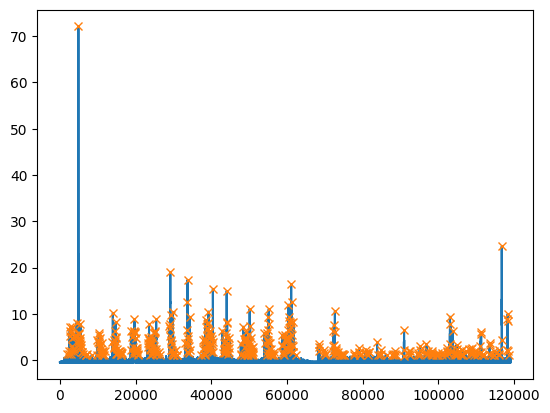

In [6]:
#for one
data = Emg2PoseSessionData(hdf5_path=stage)
channel = data['emg'].T[4]
channel = np.abs(channel)
channel = stats.zscore(channel)
#channel = channel[1500:3000]
plt.plot(channel)
peaks, _ = find_peaks(channel, prominence=1.5, distance=50)
plt.plot(peaks, channel[peaks], "x")

In [ ]:
all_spikes = []
for stage in stages:
    data = Emg2PoseSessionData(hdf5_path=stage) #one session
    start_time = data.metadata['start']
    stage = data.metadata['stage']
    session = data.metadata['session']
    user = data.metadata['user']
    semg_data = data['emg'].T
    for channelIdx, channel in enumerate(semg_data):
        channel = np.abs(channel)
        channel = stats.zscore(channel)
        peaks, properties = find_peaks(channel, prominence=1.5, distance=50)
        for i, peak in enumerate(peaks):
            duration = (
                    data.__getitem__(properties["right_bases"][i])[0]
                    - data.__getitem__(properties["left_bases"][i])[0]
                )
            time_occur = data.__getitem__(peak)[0] - start_time
            spike_token = {
                "session": session,
                "subject": user,
                "channel": channelIdx,
                "prominence": round(properties["prominences"][i], 1),
                "duration": round(duration, 2),
                "time": time_occur,
                "gesture": stage,
            }
            all_spikes.append(spike_token)

with open("data/all_spikes.pickle", "wb") as handle:
    pickle.dump(all_spikes, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(all_spikes)
print(len(all_spikes))

HandClawGraspFlicks
(16, 119266)
HandClawGraspFlicks
(16, 119266)
ShakaVulcanPeace
(16, 117131)
ShakaVulcanPeace
(16, 117131)


KeyboardInterrupt: 

(1.67031331e+09, [ 0.31061876,  0.11868303,  0.30194053,  0.7268803 , -0.09715217,  0.2263349 ,  1.0992109 ,  0.25049138, -0.11402354,  0.4537742 ,  1.3285406 ,  0.7471447 , -0.1370091 ,  0.36557704,  1.4734045 ,  0.5566268 , -0.22202021,  0.53418183,  0.8575038 ,  0.5172031 ], [-4.2359257 , -3.3382175 , -1.9568709 , -1.0360588 , -2.2315605 , -4.4715447 , -0.86546576,  0.0530066 , -2.664678  , -9.39886   ,  0.7358716 ,  5.587689  ,  6.402373  ,  1.7616893 , -0.77591664, -1.2296437 ])